In [1]:
#Import Packages
import numpy as np
from datetime import datetime 
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms as tform

import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# giving constants 
seed = 42
lr= 0.001
size_batch = 32
num_epochs = 10
i_size = 32
num_classes = 10

In [3]:
#model for LeNet5
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        #Defining the Layers
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [4]:
#instantiating LeNet5 as Model
torch.manual_seed(seed)
model = LeNet5(num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [5]:
# accuracy calculation using functions
def calculate_accuracy(model, data_loader, device):
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [6]:
#graph ploting function
def plot_graphs(train_losses, valid_losses,train_acc,valid_acc):
    fig, axs = plt.subplots(2, 1, figsize=(15,15))  
    axs[0].plot(train_losses) 
    axs[0].plot(valid_losses) 
    axs[0].title.set_text('Training Loss vs Validating Loss') 
    axs[0].legend(['Train', 'Val'])  
    axs[1].plot(train_acc) 
    axs[1].plot(valid_acc) 
    axs[1].title.set_text('Training Accuracy vs Validating Accuracy') 
    axs[1].legend(['Train', 'Val'])

In [7]:
#training the model
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    i=0
    for X,y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
        # Forward passing
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward passing
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [8]:
#validation of the Model
def validate(valid_loader, model, criterion, device):
   
    model.eval()
    running_loss = 0
    i=0
    for X,y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)
        # Forward passing and record lossing
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)
    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [9]:
#Function entiring training loop
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):

    #objects to store metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    # Training model
    for epoch in range(0, epochs):

        # training the model
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validating the model
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = calculate_accuracy(model, train_loader, device=device)
            train_accuracies.append(train_acc)
            valid_acc = calculate_accuracy(model, valid_loader, device=device)
            valid_accuracies.append(valid_acc)  
            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    #graph ploting of training loss and validating loss and accuracies
    
    return model, optimizer, (train_losses, valid_losses,train_accuracies,valid_accuracies)

In [10]:
# defining the transforms
# transforms.ToTensor() this automatically scales the images from range [0,1] 
metrics_transform= tform.Compose([tform.Resize((32, 32)),
                                 tform.ToTensor()])

# downloading and creation of datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=metrics_transform,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=metrics_transform)

# defining data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=size_batch, 
                          shuffle=False)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=size_batch, 
                          shuffle=False)

In [11]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [12]:
#fuction calling for training the model
model, optimizer, stats = training_loop(model, criterion, optimizer, train_loader, valid_loader, num_epochs, DEVICE)

Epoch: 0	Train loss: 0.2418	Train accuracy: 96.33	Valid loss: 0.1099	Valid accuracy: 96.45
Epoch: 1	Train loss: 0.0804	Train accuracy: 97.58	Valid loss: 0.0800	Valid accuracy: 97.44
Epoch: 2	Train loss: 0.0546	Train accuracy: 98.28	Valid loss: 0.0731	Valid accuracy: 97.81
Epoch: 3	Train loss: 0.0412	Train accuracy: 98.75	Valid loss: 0.0593	Valid accuracy: 98.25
Epoch: 4	Train loss: 0.0326	Train accuracy: 98.95	Valid loss: 0.0585	Valid accuracy: 98.29
Epoch: 5	Train loss: 0.0277	Train accuracy: 99.06	Valid loss: 0.0587	Valid accuracy: 98.27
Epoch: 6	Train loss: 0.0228	Train accuracy: 99.10	Valid loss: 0.0580	Valid accuracy: 98.39
Epoch: 7	Train loss: 0.0207	Train accuracy: 99.28	Valid loss: 0.0595	Valid accuracy: 98.43
Epoch: 8	Train loss: 0.0173	Train accuracy: 99.26	Valid loss: 0.0585	Valid accuracy: 98.42
Epoch: 9	Train loss: 0.0162	Train accuracy: 99.40	Valid loss: 0.0622	Valid accuracy: 98.39


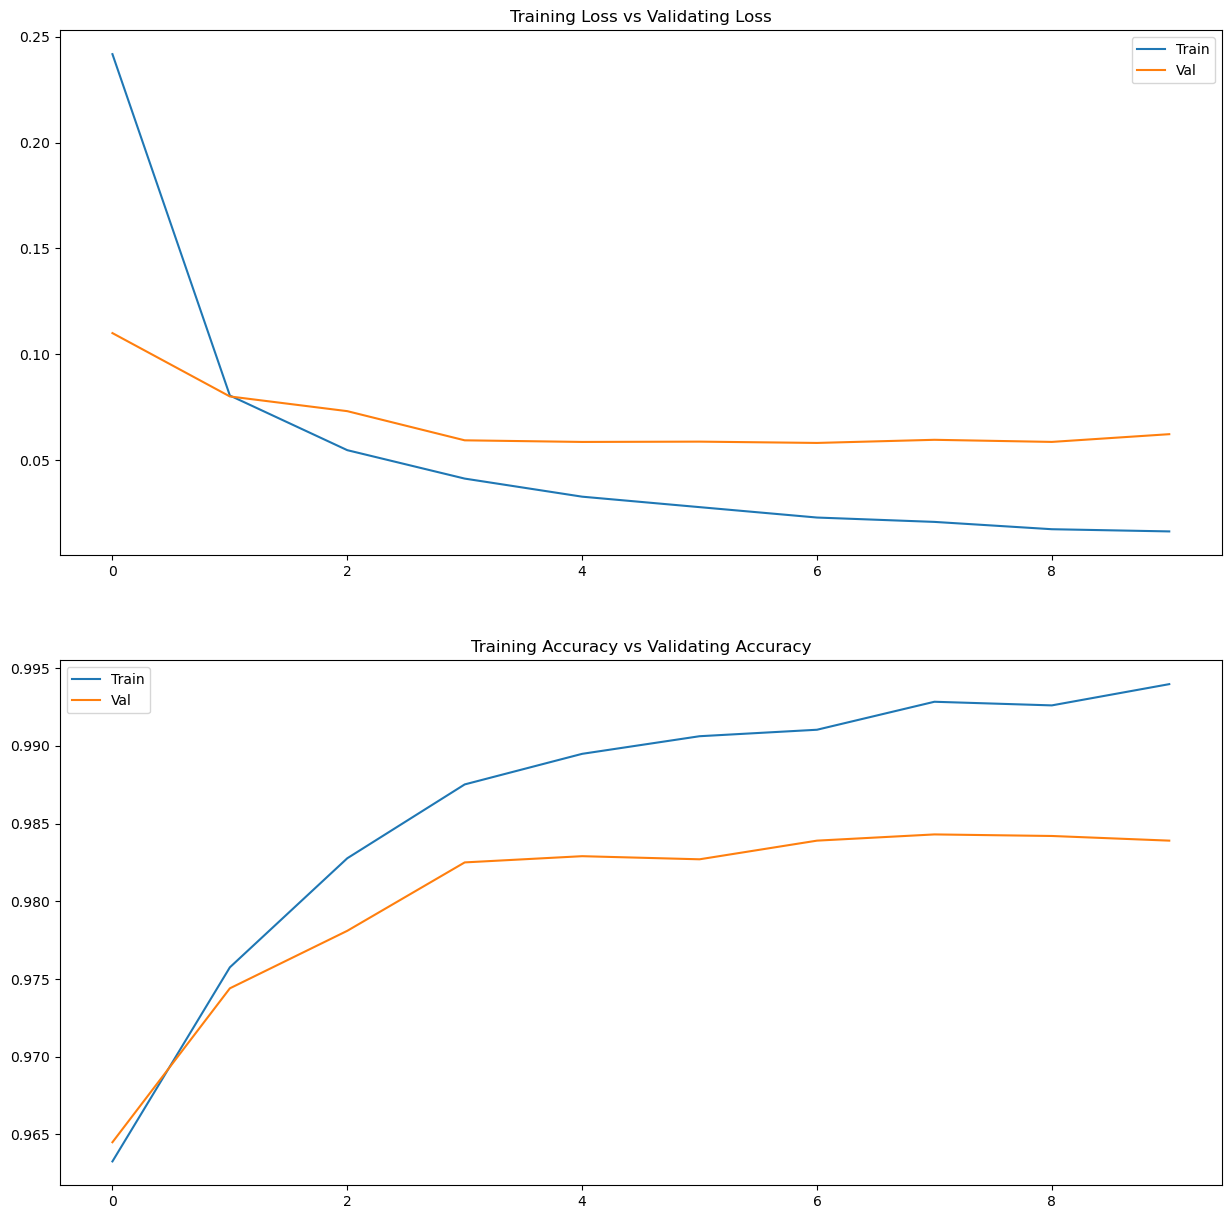

In [13]:
#graph of Training Loss over Validation loss and Training Accuracy over Validation Accuracy
plot_graphs(stats[0],stats[1],stats[2],stats[3])

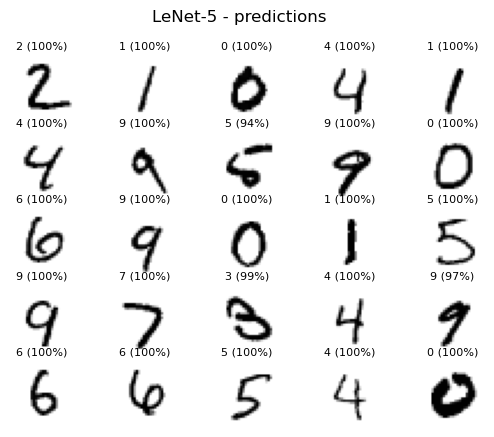

In [14]:
#Lenet-5 Model prediction

cols = 5 #No.of rows of Output 
rows = 5 #No.of Columns of Output

fig = plt.figure()
for idx in range(1, cols * rows + 1):
    plt.subplot(rows, cols, idx)
    plt.axis('off')
    plt.imshow(valid_dataset.data[idx], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[idx][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=8)
fig.suptitle('LeNet-5 - predictions');

__END__